Epoch 1/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 19s 730ms/step - accuracy: 0.5261 - loss: 15.5562
Epoch 2/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 463ms/step - accuracy: 0.5240 - loss: 0.7731
Epoch 3/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 467ms/step - accuracy: 0.5017 - loss: 0.6920
Epoch 4/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 470ms/step - accuracy: 0.4759 - loss: 0.6948
Epoch 5/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 474ms/step - accuracy: 0.5202 - loss: 0.6938
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 334ms/step - accuracy: 0.5314 - loss: 0.6902

Test Accuracy: 0.5447
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 351ms/step

Classification Report:
              precision    recall  f1-score   support

         cat       0.53      0.79      0.64        62
         dog       0.58      0.30      0.39        61

    accuracy                           0.54       123
   macro avg       0.56      0.54      0.51       123
weighted avg       0.56      0.54      0.51       123



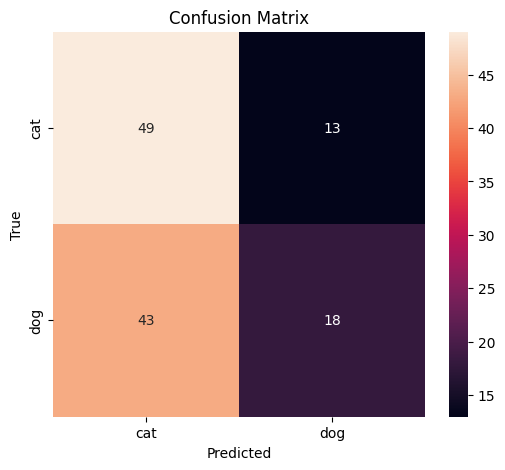

In [8]:
import os, numpy as np, cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns, matplotlib.pyplot as plt

train_dataset_path = "/content/cats-dogs-dataset/Training"
test_dataset_path  = "/content/cats-dogs-dataset/Testing"
IMG_SIZE = 224

def get_label_from_filename(filename):
    return filename.lower().split("_")[0]

def load_data(dataset_path):
    images, labels = [], []
    for file in os.listdir(dataset_path):
        if file.lower().endswith((".jpg", ".png", ".jpeg")):
            path = os.path.join(dataset_path, file)
            img = cv2.imread(path)
            if img is None: continue
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            images.append(preprocess_input(img))
            labels.append(get_label_from_filename(file))
    class_names = sorted(set(labels))
    idx = {c:i for i,c in enumerate(class_names)}
    return np.array(images), np.array([idx[l] for l in labels]), class_names

X_train, y_train, class_names = load_data(train_dataset_path)
X_test,  y_test,  _ = load_data(test_dataset_path)

y_train = keras.utils.to_categorical(y_train, num_classes=len(class_names))
y_test  = keras.utils.to_categorical(y_test,  num_classes=len(class_names))

base_model = VGG16(input_shape=(IMG_SIZE,IMG_SIZE,3), include_top=False, weights='imagenet')
base_model.trainable = True

inputs = keras.Input((IMG_SIZE,IMG_SIZE,3))
x = base_model(inputs)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(len(class_names), activation='softmax')(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=5, batch_size=32, verbose=1)

test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"\nTest Accuracy: {test_acc:.4f}")

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix"); plt.xlabel("Predicted"); plt.ylabel("True"); plt.show()